In [105]:
import torch
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

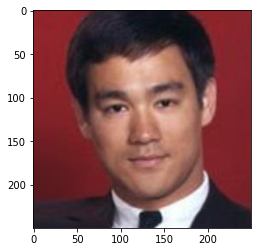

In [106]:
# visualize an image from official CASIA-WebFace dataset without aligning
img = Image.open('/home/sushang/Downloads/CASIA-WebFace/0000045/009.jpg')
img = np.array(img)

plt.imshow(img)
plt.show()

In [107]:
# visualize an image from official CASIA-WebFace dataset after aligning
img = Image.open('/home/sushang/Downloads/CASIA-WebFace-112X96/0000045/009.jpg')
img = np.array(img)

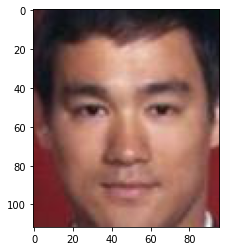

In [108]:
plt.imshow(img)
plt.show()

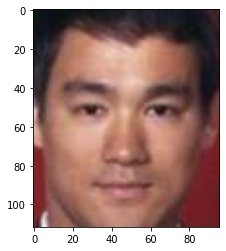

In [109]:
# create an horizontal mirror, which will be used in facial comparison
# just test the grammer here
img = img[:, ::-1, :]
plt.imshow(img)
plt.show()

In [110]:
keypoints = np.array([
    [30.2946, 51.6963],
    [65.5318, 51.5014],
    [48.0252, 71.7366],
    [33.5493, 92.3655],
    [62.7299, 92.2041]
])

In [111]:
# visualized aligned 5 keypoint locations
img = np.array(img)[:, ::-1, :].copy()
for row in range(len(keypoints)):
    cv2.circle(img, tuple(keypoints[row].astype(np.int)), 1, (255, 0, 0), 1)

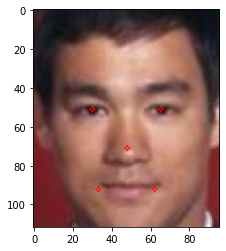

In [112]:
plt.imshow(img)
plt.show()

- seems to align perfectly in official aligned images

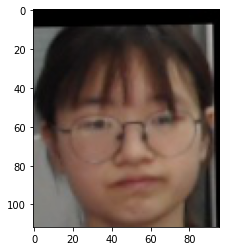

In [113]:
# visualize an image from registered image database
img = Image.open('2018011489_15.jpg')
img = np.array(img)

plt.imshow(img)
plt.show()

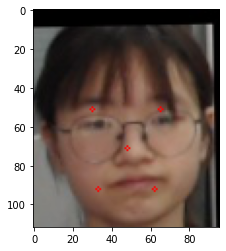

In [94]:
img = np.array(img)
for row in range(len(keypoints)):
    cv2.circle(img, tuple(keypoints[row].astype(np.int)), 1, (255, 0, 0), 1)

plt.imshow(img)
plt.show()

# Conclusion:
- [optional] It's better if face detection pipeline can give larger area of ROI (in my work)
- feature concatenation is implemented under original image and its horizontal mirror in source code (128 features -> 256)
- 5x2 keypoints variable denotes the 5 keypoints' locations defined in original training dataset, we should follow it.
- in our pipeline, these keypoints are not perfectly projected to the given position

## Now, try to only implement MTCNN to detect and re-align keypoints...

In [114]:
from facenet import MTCNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(image_size = 112, device = device)

In [115]:
img = Image.open('2018011489_15.jpg')
img_cropped, points = mtcnn(img, save_path="./2018011489_15_aligned.jpg")
print(points)

[[[34.73271  58.326714]
  [67.83093  55.654198]
  [53.85779  75.77233 ]
  [40.65255  91.232445]
  [68.29912  88.52232 ]]]


/home/sushang/MobileFaceNet_Pytorch-master/facenet/models/utils/detect_face.py:183: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  mask_inds = mask.nonzero()


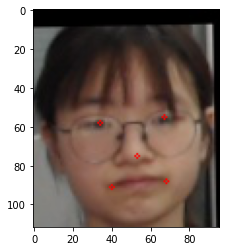

In [116]:
img = np.array(img)

for point in points:
    for row in range(len(point)):
        cv2.circle(img, tuple(point[row].astype(np.int)), 1, (255, 0, 0), 1)

plt.imshow(img)

- detected keypoints are not aligned to ideal places, current location is only robust for detection part
- so, keypoint positioning in MTCNN is correct.. something must be wrong in projection pipeline
- now try to implement my reprojection method...

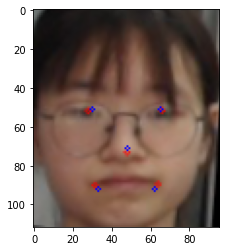

In [119]:
from skimage import transform as trans

tform = trans.SimilarityTransform()
tform.estimate(points[0], keypoints)
M = tform.params[0:2,:]
warped = cv2.warpAffine(img,M,(96, 112), borderValue = 0.0)

# visualize standard keyppoint location in blue
for row in range(len(keypoints)):
    cv2.circle(warped, tuple(keypoints[row].astype(np.int)), 1, (0, 0, 255), 1)

plt.imshow(warped)

- reproject the detected 5 keypoints to standard locations, the result is correct.
- so this part is over, next try to check the face detection part to search for improvement~